<a href="https://colab.research.google.com/github/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Train_TFLite1_Object_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite v1 Object Detection API in Colab
**Author:** Evan Juras, [EJ Technology Consultants](https://ejtech.io)

**Last updated:** 10/12/22

**GitHub:** [TensorFlow Lite Object Detection](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi)


# Introduction

This notebook implements [The TensorFlow Object Detection Library](https://github.com/tensorflow/models/tree/master/research/object_detection) for training an SSD-MobileNet model using your own dataset. Note that this notebook uses TensorFlow 1 rather than TensorFlow 2, because TensorFlow 1 works better for quantizing SSD-MobileNet models. If you want to use TensorFlow 2, [clink this link to go to the TensorFlow 2 version of this notebook](https://colab.research.google.com/github/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Train_TFLite2_Object_Detction_Model.ipynb).

*Note: This notebook is not maintained or updated as frequently as the TF2 notebook.*

I made a YouTube video that walks through the TensorFlow 2 notebook step by step, and the process is very similar for this TensorFlow 1 notebook. Please take a look at the video if you are confused about any steps in this notebook.

*Link to video to be added here*

###Working with Colab
Simply click the play button on sections of code to execute them. As the code executes, any outputs will be displayed in a block beneath the code. Once they're done executing, a green checkmark will appear next to the section to indicate it's finished running.

# 1. Install TensorFlow Object Detection Dependencies
First, we'll install the TensorFlow Object Detection API in this Google Colab instance. This requires cloning the [TensorFlow models repository](https://github.com/tensorflow/models) and running a couple installation commands. Click the play button to run the following sections of code.



In [ ]:
# Install CUDA 10.0 (needed for TF v1.15.3)
!sudo apt-get update
!sudo apt-get install cuda-10.0

In [ ]:
# Install cuDNN 7.6.0 (needed for TF v1.15.3)
# Download and extract cuDNN files
!wget https://www.dropbox.com/s/k6xqrje655q4aty/cudnn-10.0-linux-x64-v7.6.0.64.tgz
!tar -xf cudnn-10.0-linux-x64-v7.6.0.64.tgz

# Copy cuDNN libraries to appropriate folders
!sudo cp cuda/include/cudnn*.h /usr/local/cuda-10.0/include 
!sudo cp -P cuda/lib64/libcudnn* /usr/local/cuda-10.0/lib64 
!sudo chmod a+r /usr/local/cuda-10.0/include/cudnn*.h /usr/local/cuda-10.0/lib64/libcudnn*
!sudo cp -P cuda/lib64/libcudnn* /usr/lib64-nvidia

In [ ]:
# Clone the tensorflow models repository from GitHub
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf1/setup.py .
python -m pip install --use-feature=2020-resolver .

If you get any errors running the following code block, you can ignore them!

In [ ]:
# Install TensorFlow
!pip install tensorflow-gpu==1.15.3

# A couple other packages have to be downgraded to work with the TF1 API
!pip install numpy==1.17.4
!pip install pycocotools==2.0.0

In [ ]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/models/research/object_detection/builders/model_builder_tf1_test.py


# 2. Upload Image Dataset and Prepare Training Data

In this section, we'll upload our training images and use TFRecord generation scripts to prepare the training data for TensorFlow. we'll upload our images, split them into train, validation, and test folders, and then run scripts for creating TFRecords from our data.

First, on your local PC, zip all your training images and XML files into a single folder called "images.zip". The files should be directly inside the zip folder (wihout any additional nested folders) as shown below:
```
images.zip
-- img1.jpg
-- img1.xml
-- img2.jpg
-- img2.xml
...
```
There are two options for moving the image files to this Colab instance: you can upload them directly, or you can copy them from your Google Drive. If you have a slow internet connection or more than 50MB worth of images, I recommend using Google Drive. Otherwise, you can just upload them through Colab. 

#### Option 1. Upload through Google Colab
Upload the "images.zip" file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

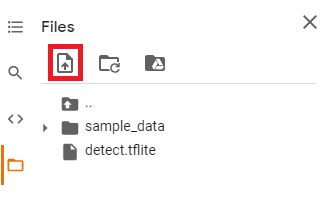

Once it's uploaded, we'll run a few commands to unzip it and set up our image directories. These directories are created in the /content folder in this instance's filesystem. You can browse the filesystem by clicking the "Files" icon on the left.


#### Option 2. Copy from Google Drive
You can also upload your images to your personal Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. This option works well if you want to upload the images beforehand so you don't have to wait for them to upload each time you restart this Colab.

First, upload the "images.zip" file to your Google Drive, and make note of the folder you uploaded them to. Replace `MyDrive/path/to/images.zip` with the path to your zip file. (For example, I uploaded the zip file to folder called "cat-toys1", so I would use `MyDrive/cat-toys1/images.zip` for the path). Then, run the following block of code to mount your Google Drive to this Colab session and copy the folder to this filesystem.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/images.zip /content

#### Option 3. Use my bird, squirrel, raccoon dataset
I've uploaded a dataset containing 800 labeled images of birds, squirrels, and raccoons. You can use this dataset if you just want to work through the process of training a TFLite model on custom data. Run the following code block to download the dataset.

In [ ]:
!wget -O /content/images.zip https://www.dropbox.com/s/en33x280e4z3wbt/BSR2.zip?dl=0

## Split images into train, validation, and test folders
At this point, whether you used Option 1, 2, or 3, you should be able to click the folder icon on the left and see your "images.zip" file in the list of files. Now that the dataset is uploaded, let's unzip it and create some folders to hold the images. These directories are created in the /content folder in this instance's filesystem. You can browse the filesystem by clicking the "Files" icon on the left.

In [ ]:
!mkdir /content/images
!unzip -q images.zip -d /content/images/all
!mkdir /content/images/train; mkdir /content/images/validation; mkdir /content/images/test


Next, we'll split the images into train, validation, and test sets. Here's what each set is used for:


*   **Train**: These are the actual images used to train the model. In each step of training, a batch of images from the "train" set is passed into the neural network. The network predicts classes and locations of objects in the images. The training algorithm calculates the loss (i.e. how "wrong" the predictions were) and adjusts the network weights through backpropagation.


*   **Validation**: Images from the "validation" set can be used by the training algorithm to check the progress of training and adjust hyperparameters (like learning rate). Unlike "train" images, these images are only used periodically during training (i.e. once every certain number of training steps).


* **Test**: These images are never seen by the neural network during training. They are intended to be used by a human to perform final testing of the model to check how accurate the model is.

I wrote a Python script to randomly move 80% of the images to the "train" folder, 10% to the "validation" folder, and 10% to the "test" folder. Click play on the following block to download the script and execute it.

In [ ]:
!wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/train_val_test_split.py
!python train_val_test_split.py

## Create TFRecords
Finally, we need to convert the images into a data file format called TFRecords, which are used by TensorFlow for training. We'll use Python scripts to automatically convert the data into TFRecord format. Before running them, we need to define a labelmap for our classes. 

The code section below will create a "labelmap.txt" file that contains a list of classes. Replace the `class1`, `class2`, `class3` text with your own classes (for example, `bird`, `squirrel`, `raccoon`), adding a new line for each class. Then, click play to execute the code.

In [ ]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF >> /content/labelmap.txt
class1
class2
class3
EOF

Download and run the data conversion scripts by clicking play on the following two sections of code. They will create TFRecord files for the train and validation datasets, as well as a `labelmap.pbtxt` file which contains the labelmap in a different format.

In [ ]:
# Download data conversion scripts
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py

In [ ]:
# Create CSV data files and TFRecord files
!python3 create_csv.py
!python3 create_tfrecord.py --csv_input=images/train_labels.csv --labelmap=labelmap.txt --image_dir=images/train --output_path=train.tfrecord
!python3 create_tfrecord.py --csv_input=images/validation_labels.csv --labelmap=labelmap.txt --image_dir=images/validation --output_path=val.tfrecord

We'll store the locations of the TFRecord and labelmap files as variables so we can reference them later in this Colab session.

In [ ]:
train_record_fname = '/content/train.tfrecord'
val_record_fname = '/content/val.tfrecord'
label_map_pbtxt_fname = '/content/labelmap.pbtxt'

# 3. Set Up Training Configuration 

In this section, we'll set up an SSD-MobileNet model training configuration. We'll specifiy which pretrained TensorFlow model we want to use from the [TensorFlow 1 Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md). Each model also comes with a configuration file that points to file locations, sets training parameters (such as learning rate and total number of training steps), and more. We'll modify the configuration file for our custom training job.

The first section of code lists out some models availabe in the TF1 Model Zoo and defines some filenames that will be used later to download the model and config file. This makes it easy to manage which model you're using and to add other models to the list later. 

Set the "chosen_model" variable to match the name of the model you'd like to train with. It's currently set to use the "ssd-mobilenet-v1-quantized" model. Then, click play on the next three sections to specify and download the pretrained model file and configuration file.


In [ ]:
# Change the "chosen_model" variable to select one of the models listed below (from the TF1 object detection zoo)

chosen_model = 'ssd-mobilenet-v2-quantized'

MODELS_CONFIG = {
    'ssd-mobilenet-v1-quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_coco',
        'base_pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz',
    },
    'ssd-mobilenet-v2-quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_coco',
        'base_pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz',
    }
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

In [ ]:
# Create "mymodel" folder for holding pre-trained weights and configuration files
%mkdir /content/models/mymodel/
%cd /content/models/mymodel/

# Download pretrained model file from TensorFlow Model Zoo
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Download base training configuration file
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/samples/configs/' + base_pipeline_file
!wget {download_config}

Now that we've downloaded our model and config file, we need to modify the configuration file with some high-level training parameters. The following variables are used to control training steps:

* **num_steps**: The total amount of steps to use for training the model. A good number to start with is 40,000 steps. You can use more steps if you notice the loss metrics are still decreasing by the time training finishes. The more steps, the longer the training. Training can also be stopped early if loss flattens out before reaching the specified number of steps.
* **batch_size**: The number of images to use per training step. A larger batch size allows a model to be trained in fewer steps, but the size is limited by the GPU memory available for training. For the GPUs used in Colab instances, 16 is typically a good number.

* **quant_delay_steps**: (Only used for quantization-aware training) After this many steps, the training algorithm will insert "fake" quantization nodes in the network to simulate the effects of quantization. A good starting point is half the total number of training steps. More information is available [here](https://neuralet.com/article/quantization-of-tensorflow-object-detection-api-models/).

Other training information, like the location of the pretrained model file, the config file, and total number of classes are also assigned in this step.


In [ ]:
# Set training parameters for the model
num_steps = 30000
batch_size = 16
quant_delay_steps = 15000

In [ ]:
# Set file locations and get number of classes for config file
pipeline_fname = '/content/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/mymodel/' + model_name + '/model.ckpt'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)


Finally, we'll rewrite the config file to use the training parameters we just specified. The following section of code will automatically replace the necessary parameters in the downloaded .config file and save it as our custom "pipeline_file.config" file.

In [ ]:
# Write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file
# TO DO: change that description

import re

%cd /content/models/mymodel
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/mscoco_train.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/mscoco_val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    # Fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
    
    # Quantization delay steps
    s = re.sub(
        'delay: 48000', 'delay: {}'.format(quant_delay_steps), s)
        
    f.write(s)

%cd /content


In [ ]:
# Display the custom configuration file's contents
!cat /content/models/mymodel/pipeline_file.config

In [ ]:
# Set the path to the custom config file, and the directory to store training checkpoints in
pipeline_file = '/content/models/mymodel/pipeline_file.config'
model_dir = '/content/training/'

The next block modifies the training script to save checkpoints once every 1000 training steps. Change `num_eval_steps` if you'd like to save checkpoints more or less frequently.

In [ ]:
# Modify model_main.py to set evaluation and checkpoint interval
num_eval_steps = 1000
%cd /content/models/research/object_detection
print('Modifying model_main.py')


with open('model_main.py', 'r') as f:
  data = f.read()

  # Set eval steps
  data = data.replace('config = tf_estimator.RunConfig(model_dir=FLAGS.model_dir)', 
             'config = tf.estimator.RunConfig(model_dir=FLAGS.model_dir, save_checkpoints_steps={})'.format(num_eval_steps))
  
  f.close()

!rm /content/models/research/object_detection/model_main.py

with open('model_main.py', 'w') as f:
  f.write(data)

%cd /content

In [ ]:
!cat /content/models/research/object_detection/model_main.py

# Train Custom TF1 Object Detector

We're ready to train our object detection model! Model training is performed using the "model_main_tf2.py" script from the TF Object Detection API. We've already defined all the parameters and arguments used by `model_main_tf2.py` in previous sections of this Colab. Training will take anywhere from 2 to 6 hours, depending on the model, batch size, and number of training steps. Just click Play on the following block to begin training!

*Note: It takes a few minutes for the program to display any training messages, because it only displays logs once every 100 steps. If it seems like nothing is happening, just wait a couple minutes.*

*Another note: If you want to stop training early, just click on the code block while it's running and press Ctrl+M to interrupt execution. You might have to press Ctrl+M a couple times and also click the Stop button or right-click and select "Interrupt Execution".*


In [ ]:
!pip install tensorboard==2.8.0

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training'

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps}

# 5. Export Trained Inference Graph
In the left sidebar, click the folder icon to view the files in the `/content` folder. Click the `training` folder to expand it, and find the checkpoint with the highest number (e.g. `model.ckpt-29000`). Replace "XXXX" in the code section below with that number.

In [ ]:
!mkdir /content/fine_tuned_model_lite
output_directory = '/content/fine_tuned_model_lite'

# Replace "XXXX" in the line below with the latest checkpoint in the /content/training directory
last_model_path = '/content/training/model.ckpt-30000'
print(last_model_path)

!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --trained_checkpoint_prefix {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

# 6. Convert Model to TensorFlow Lite Format

In [ ]:
localpb = '/content/fine_tuned_model_lite/tflite_graph.pb'
tflite_file = '/content/fine_tuned_model_lite/detect.tflite'

# Can use Netron app to determine the input size: https://www.electronjs.org/apps/netron 
input_size = [1, 300, 300, 3]
input_shape = {"normalized_input_image_tensor" : input_size}

print(input_shape)

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_frozen_graph(
    localpb, 
    ["normalized_input_image_tensor"],
    ["TFLite_Detection_PostProcess","TFLite_Detection_PostProcess:1","TFLite_Detection_PostProcess:2","TFLite_Detection_PostProcess:3"],
    input_shape
)

converter.allow_custom_ops = True
converter.inference_type = tf.uint8  # Tell converter to create a quantized model
converter.quantized_input_stats = {'normalized_input_image_tensor': (128, 128)}

tflite_model = converter.convert()

open(tflite_file,'wb').write(tflite_model)

# Test that the conversion was successful - if any errors are generated, something went wrong!
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [ ]:
!cp /content/labelmap.txt /content/fine_tuned_model_lite
!cp /content/labelmap.pbtxt /content/fine_tuned_model_lite
!zip -r /content/fine_tuned_model_lite.zip /content/fine_tuned_model_lite

Now, you can download the "detect.tflite" and "labelmap.txt" files and move them to your Raspberry Pi.

# (Optional) Test out TensorFlow Lite Model
Now that we've got our custom detection model trained and converted to TFLite format, let's try it out on some images. We'll use the images from our "test" folder. These images weren't seen at all by the model during training, so they'll give a faithful depiction of how accurate the model actually is.

The following code is used to import the TensorFlow Lite runtime, load it into memory, run inferencing on the test images, and display the results.

In [ ]:
# Copied from my TFLite repository, and stripped unneeded stuff out

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

PATH_TO_IMAGES='/content/images/test'
PATH_TO_MODEL='/content/fine_tuned_model_lite/detect.tflite'
PATH_TO_LABELS='/content/labelmap.txt'
IMAGES_TO_TEST = 10
min_conf_threshold=0.5

# Grab all image filenames
images = glob.glob(PATH_TO_IMAGES + '/*.jpg')
images = images + glob.glob(PATH_TO_IMAGES + '/*.JPG')
images = images + glob.glob(PATH_TO_IMAGES + '/*.png')


# Load the label map into memory
with open(PATH_TO_LABELS, 'r') as f:
    labels = [line.strip() for line in f.readlines()]


# Load the Tensorflow Lite model into memory
interpreter = Interpreter(model_path=PATH_TO_MODEL)
interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5

# Loop over every image and perform detection
for image_path in images[0:IMAGES_TO_TEST]:

    # Load image and resize to expected shape [1xHxWx3]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imH, imW, _ = image.shape 
    image_resized = cv2.resize(image_rgb, (width, height))
    input_data = np.expand_dims(image_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # Perform the actual detection by running the model with the image as input
    interpreter.set_tensor(input_details[0]['index'],input_data)
    interpreter.invoke()

    # Retrieve detection results
    boxes = interpreter.get_tensor(output_details[0]['index'])[0] # Bounding box coordinates of detected objects
    classes = interpreter.get_tensor(output_details[1]['index'])[0] # Class index of detected objects
    scores = interpreter.get_tensor(output_details[2]['index'])[0] # Confidence of detected objects
    #num = interpreter.get_tensor(output_details[3]['index'])  # Total number of detected objects (inaccurate and not needed)

    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # All the results have been drawn on the image, now display the image
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,16))
    plt.imshow(image)
    plt.show()

## (Optional) Compile Model for Edge TPU

Now that the model has been converted to TFLite and quantized, we can compile it to run on Edge TPU devices like the [Coral USB Accelerator](https://coral.ai/products/accelerator/) or the [Coral Dev Board](https://coral.ai/products/dev-board/). This allows the model to run much faster! For more information on the Edge TPU, see my [TensorFlow Lite repository on GitHub](fine_tuned_model_lite).

First, install the Edge TPU Compiler package inside this Colab instance.

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler	

Next, compile the model. (If your model has a different filename than "detect.tflite", use that instead.)

In [ ]:
%cd /content/fine_tuned_model_lite
!edgetpu_compiler detect.tflite
!mv detect_edgetpu.tflite edgetpu.tflite

The compiled model will be output in the /content folder as "detect_edgetpu.tflite". It gets renamed to "edgetpu.tflite" to be consistent with my code. Download this file using the command below. (If your model has a different filename than "edgetpu.tflite", use that instead.)

In [ ]:
%cd /content
!cp labelmap.txt fine_tuned_model_lite
!cp labelmap.pbtxt fine_tuned_model_lite
!zip -r fine_tuned_model_lite.zip fine_tuned_model_lite

In [ ]:
from google.colab import files

files.download('edgetpu.tflite')

Now you're all set to use the Coral model! For instructions on how to run an object detection model on the Raspberry Pi using the Coral USB Acclerator, please see my video, ["How to Use the Coral USB Accelerator with the Raspberry Pi"](https://www.youtube.com/watch?v=qJMwNHQNOVU).